Script to compute matrices of precipitation accumulation and of NEPs on SAFRAN moving sub-domains of a given size

In [1]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from config import *
from utils import *
from make_acc_nep_SAFR import load_mat_SAFR_sub

R[write to console]: Le chargement a nécessité le package : kde1d



In [2]:
### CST ###

reg = 'Fr'
dataset = 'SAFRAN'
ymin = 1958
ymax = 2021
years = np.arange(ymin, ymax+1, 1)
per = str(ymin) + '-' + str(ymax)
sizes = [10, 30, 50]  # domain side length (number of pixels)
prop = 0.33  # proportion du côté de la fenêtre sans recouvrement (dans les deux directions)
th_n = 0.75  # minimum proportion of land grid cell for the sub-domain to be considered
nbweeksmin = 4
nbweeksmax = 166  # 260
ts = str(nbweeksmin) + '-' + str(nbweeksmax)
mm = np.arange(1, 12+1,1)
typ = 'kernall'  # Method to compute NEPs

projmap = ccrs.LambertConformal(central_longitude=2.337229, central_latitude=46.8, false_easting=600000., false_northing=2200000.)
resol = '50m'  # use data at this scale
bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)

In [3]:
# Get France polygon and reprojectin SAFRAN CRS
cnydbffile = SHAPEDIR + '/world-boundaries/world-administrative-boundaries.dbf'
dfcny = gpd.read_file(cnydbffile)
dffra = gpd.GeoSeries(dfcny.iloc[93]['geometry'])
dffra.set_crs(dfcny.crs, inplace=True)
dffra_reproj = dffra.to_crs(proj)

In [4]:
#~ OUTDIR

if not os.path.isdir(FIGDIR + '/for_article'):
    os.mkdir(FIGDIR + '/for_article')
figdir = FIGDIR + '/for_article'

In [5]:
ds = get_data_yr_SAFR(1960)


>>> 80x80 <<<
(84000, 2337000) : (132000, 2337000) : (156000, 2289000) : (180000, 2337000) : (204000, 2289000) : (228000, 2241000) : (228000, 2337000) : (252000, 2193000) : (252000, 2289000) : (276000, 2145000) : (276000, 2241000) : (276000, 2337000) : (300000, 1809000) : (300000, 1905000) : (300000, 2097000) : (300000, 2193000) : (300000, 2289000) : (300000, 2385000) : (324000, 1761000) : (324000, 1857000) : (324000, 1953000) : (324000, 2049000) : (324000, 2145000) : (324000, 2241000) : (324000, 2337000) : (324000, 2433000) : (348000, 1809000) : (348000, 1905000) : (348000, 2001000) : (348000, 2097000) : (348000, 2193000) : (348000, 2289000) : (348000, 2385000) : (372000, 1761000) : (372000, 1857000) : (372000, 1953000) : (372000, 2049000) : (372000, 2145000) : (372000, 2241000) : (372000, 2337000) : (372000, 2433000) : (396000, 1809000) : (396000, 1905000) : (396000, 2001000) : (396000, 2097000) : (396000, 2193000) : (396000, 2289000) : (396000, 2385000) : (420000, 1761000) : (42000

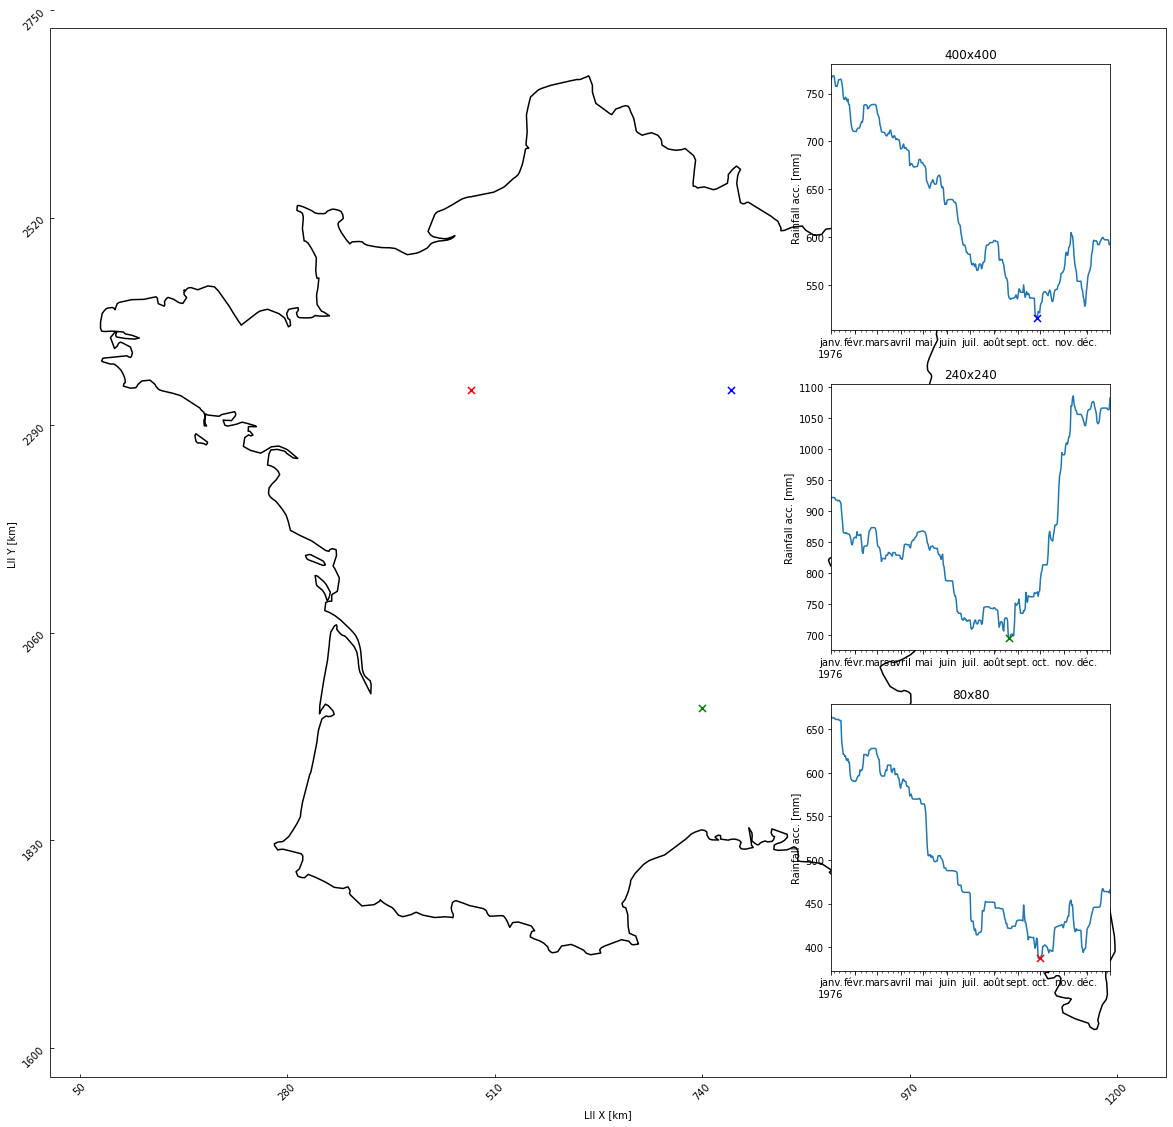

In [13]:
#~ Plot

timescale = 52  # weeks
y2plot = 1976

xlims = (50000., 1200000.)
ylims = (1600000., 2750000.)
xtcks = np.linspace(xlims[0], xlims[1], 6)
ytcks = np.linspace(ylims[0], ylims[1], 6)
xtlbs = [int(xt/1000) for xt in xtcks]
ytlbs = [int(yt/1000) for yt in ytcks]

xaxin = 0.7
yaxin = 0.1

fig, ax = plt.subplots(figsize=(20., 20.), subplot_kw={'projection': projmap})

mcs = ['r', 'g', 'b']

for isize, size in enumerate(sizes):
    size_ = str(int(size*res/1000)) + 'x' + str(int(size*res/1000))
    print('\n>>> {0} <<<'.format(size_))

    step = int(round(size * prop, 0))  # décalage dans la sélection des coordonnées des sous-fenêtres
    ntot = size **2  # total number of pixel within domain

    #~ Get valid cells to compute matrices of precip. acc. and NEPs -> ALREADY DONE (METHOD 1)
    # Min and max coordinates (x, y) of the lower left pixel of sub-domains
    x_min_ = x_min
    x_max_ = x_max - size * res
    x_min_, x_max_
    y_min_ = y_min
    y_max_ = y_max - size * res
    (x_min_, y_min_), (x_max_, y_max_)

    # Coordinates of the lower left pixel of all sub-domains
    xs = pd.Series(np.arange(x_min_, x_max_+res, res))  # all x coordinates
    ys = pd.Series(np.arange(y_min_, y_max_+res, res))  # all y coordinates

    # Sub-sample sub-domains coordinates (-> over-lapping)
    xs_ = xs[::step]
    ys_ = ys[::step]

    # Get all subdomains lower left (ll) coordinates (x, y)
    ll_cells = []
    for x in xs_:
        for y in ys_:
            ll_cells.append((x, y))
    len(ll_cells)

    # Get valid sub-domains: containing at least X % of land grid cells
    valid_cells = []

    for ll_cell in ll_cells:
        x_min_ = ll_cell[0]
        x_max_ = x_min_ + size * res - res
        y_min_ = ll_cell[1]
        y_max_ = y_min_ + size * res - res
        xs = [x_min_, x_max_]
        ys = [y_min_, y_max_]

        data = ds.sel(x=slice(x_min_, x_max_), y=slice(y_min_, y_max_)).mean(dim='time').product.values

        if len(data[~np.isnan(data)]) >= ntot*th_n:
            valid_cells.append((xs, ys))
            print(ll_cell, end=' : ', flush=True)

    #len(valid_cells)
    
    # Load matrix of precipitation accumulation

    icell = np.random.randint(0, high=len(valid_cells), size=1)[0]
    cell = valid_cells[icell]
    coord = (cell[0][0], cell[1][0])  # xmin, ymin

    mat = load_mat_SAFR_sub(reg, ymin, ymax, nbweeksmin, nbweeksmax, cell[0], cell[1], size)
    ygps = mat.groupby(mat.index.year).groups
    iyr = ygps[y2plot]
    mat_y = mat.loc[iyr][timescale]
    
    # Plot centers

    x_center = coord[0] + size * res / 2
    y_center = coord[1] + size * res / 2

    ax.scatter(x_center, y_center, s=50, c=mcs[isize], marker='x', zorder=100)

    axin = ax.inset_axes([xaxin, yaxin, 0.25, 0.25])
    mat_y.plot(ax=axin)
    axin.scatter(axin.get_xlim()[0]+np.argmin(mat_y.values), mat_y.min(), s=50, color=mcs[isize], marker='x', zorder=100)
    axin.set_ylabel('Rainfall acc. [mm]'.format(timescale))
    axin.set_title(size_)

    yaxin = yaxin+0.3


dffra_reproj.boundary.plot(ax=ax, color='k')

ax.set_xticks(xtcks)
ax.set_yticks(ytcks)
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')
ax.set_xticklabels(xtlbs, rotation=45)
ax.set_xlabel('LII X [km]')
ax.set_yticklabels(ytlbs, rotation=45)
ax.set_ylabel('LII Y [km]')

#~ Save

figfile = figdir + '/fig4.png'

fig.savefig(figfile)